In [1]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
import pickle
import time
import multiprocessing as mp
import numpy as np
import pandas as pd
import spacy
import warnings
warnings.filterwarnings('ignore')

In [25]:
from ast import literal_eval 

In [47]:
import re

In [34]:
infor_tb = pd.read_csv('frauds_table_0520.csv')

In [35]:
infor_tb = infor_tb.drop(['Unnamed: 0'],axis =1)


In [36]:
infor_tb['information_item7'] = infor_tb['information_item7'].apply(literal_eval)

In [39]:
infor_tb['information_item7'] = infor_tb['information_item7'].apply(lambda x: x[0])

In [40]:
infor_tb.head(3)

,file,information_item7,structure,SIC,CIK,date,type,comp_name,success,yeara,map_key,fraud_match,fraud_match_lag
0,edgar/data/1122304/0001122304-16-000201.txt,/home/jujun/pyproject/research/jujun/frauds_fi...,"{'item12': 1, 'item6': 0, 'item9b': 0, 'item3'...",hospital & medical service plans [6324],1122304,2015-12-31,10-k,aetna inc /pa/,1,2015,1122304_2015,0,0
1,edgar/data/1122304/0000950123-03-002268.txt,/home/jujun/pyproject/research/jujun/frauds_fi...,"{'item12': 4, 'item6': 0, 'item7a': 0, 'item3'...",hospital & medical service plans [6324],1122304,2002-12-31,10-k,aetna inc /pa/,0,2002,1122304_2002,0,0
2,edgar/data/1122304/0000950123-04-002526.txt,/home/jujun/pyproject/research/jujun/frauds_fi...,"{'item12': 4, 'item15': 0, 'item6': 0, 'item7a...",hospital & medical service plans [6324],1122304,2003-12-31,10-k,aetna inc /pa/,1,2003,1122304_2003,0,0


In [41]:
infor_tb.yeara.value_counts().sort_index()

1993     62
1994     70
1995    198
1996    342
1997    357
1998    351
1999    375
2000    377
2001    357
2002    333
2003    329
2004    314
2005    306
2006    288
2007    283
2008    271
2009    256
2010    243
2011    222
2012    207
2013    194
2014    183
2015    169
2016    159
2017     27
Name: yeara, dtype: int64

In [42]:
infor_tb.head()

,file,information_item7,structure,SIC,CIK,date,type,comp_name,success,yeara,map_key,fraud_match,fraud_match_lag
0,edgar/data/1122304/0001122304-16-000201.txt,/home/jujun/pyproject/research/jujun/frauds_fi...,"{'item12': 1, 'item6': 0, 'item9b': 0, 'item3'...",hospital & medical service plans [6324],1122304,2015-12-31,10-k,aetna inc /pa/,1,2015,1122304_2015,0,0
1,edgar/data/1122304/0000950123-03-002268.txt,/home/jujun/pyproject/research/jujun/frauds_fi...,"{'item12': 4, 'item6': 0, 'item7a': 0, 'item3'...",hospital & medical service plans [6324],1122304,2002-12-31,10-k,aetna inc /pa/,0,2002,1122304_2002,0,0
2,edgar/data/1122304/0000950123-04-002526.txt,/home/jujun/pyproject/research/jujun/frauds_fi...,"{'item12': 4, 'item15': 0, 'item6': 0, 'item7a...",hospital & medical service plans [6324],1122304,2003-12-31,10-k,aetna inc /pa/,1,2003,1122304_2003,0,0
3,edgar/data/1122304/0001122304-15-000038.txt,/home/jujun/pyproject/research/jujun/frauds_fi...,"{'item12': 1, 'item6': 0, 'item9b': 0, 'item3'...",hospital & medical service plans [6324],1122304,2014-12-31,10-k,aetna inc /pa/,1,2014,1122304_2014,0,0
4,edgar/data/1122304/0001122304-12-000045.txt,/home/jujun/pyproject/research/jujun/frauds_fi...,"{'item12': 1, 'item6': 0, 'item9b': 0, 'item3'...",hospital & medical service plans [6324],1122304,2011-12-31,10-k,aetna inc /pa/,1,2011,1122304_2011,0,0


In [43]:
nlp = spacy.load('en_core_web_sm',disable = ['ner','parser'])

In [44]:
def clean_text(text):
    paras_cl = []
    paras = text.split("\n\n")
    #print(paras)
    for para in paras:
        #print(para)
        p1 = re.findall("[a-zA-Z]", para.lower())
        num_p = len(p1)
        #print(num_p)

        p2 = re.sub("[^a-zA-Z]"," ",para)
        space_num = p2.count(' ')
        #print(space_num)

        if num_p*2 < space_num:
            para = ""   
        elif num_p <= 25:
            para = ""
        else:pass
        paras_cl.append(para)
        
    para_cl_fl = list(filter(None,paras_cl))
    para_cl_fl_2 = [re.sub(r"\n"," ",i) for i in para_cl_fl]
    

    para_cl_fl_3 = []
    for p_2 in para_cl_fl_2:
        para_list = []
        t_convert = nlp(p_2)
        for token in t_convert:
            
            if token.pos_ == 'NUM':
                para_list.append('dd')
            else: para_list.append(token)
            
        para_list_1 = [str(p) for p in para_list]
        para_list_2 = ' '.join(para_list_1)
        para_cl_fl_3.append(para_list_2)
        
    return para_cl_fl_3

In [45]:
def text_prepare(x, df):
    with open(df.information_item7[x]) as f:
        text = f.read()
    f.close() 
    text_cl = clean_text(text)
    return (text_cl, df.fraud_match[x], df.CIK[x], df.yeara[x], df.file[x], df.fraud_match_lag[x])

In [48]:
threads = 0
finishes = 0
pool=mp.Pool(processes=10)
results = []
text_para = []
start= time.time()
for idx in infor_tb.index:
    
    threads += 1
    if threads%100 == 0:
        print("send process {}".format(threads))
      
    results.append(pool.apply_async(text_prepare, args=(idx,infor_tb)))

for rs in results:
    finishes+=1
    if finishes%10000 == 0:
        print("finish process {} @ {}".format(finishes, time.time()-start))
    text_para.append(rs.get())     

send process 100
send process 200
send process 300
send process 400
send process 500
send process 600
send process 700
send process 800
send process 900
send process 1000
send process 1100
send process 1200
send process 1300
send process 1400
send process 1500
send process 1600
send process 1700
send process 1800
send process 1900
send process 2000
send process 2100
send process 2200
send process 2300
send process 2400
send process 2500
send process 2600
send process 2700
send process 2800
send process 2900
send process 3000
send process 3100
send process 3200
send process 3300
send process 3400
send process 3500
send process 3600
send process 3700
send process 3800
send process 3900
send process 4000
send process 4100
send process 4200
send process 4300
send process 4400
send process 4500
send process 4600
send process 4700
send process 4800
send process 4900
send process 5000
send process 5100
send process 5200
send process 5300
send process 5400
send process 5500
send process 5600
s

In [54]:
with open('fraudsdata_20200525_2012', 'wb') as fp:
     pickle.dump(text_para, fp)
fp.close()

In [58]:
text_para[0]

(['quantitative and qualitative disclosures about market risk',
  "item dd .   management 's discussion and analysis of financial condition and results of operations",
  'the information contained in the md&a , beginning on page dd of the annual report , is incorporated herein by reference .',
  'item dd .   quantitative and qualitative disclosures about market risk',
  'the information contained in the " risk management and market - sensitive instruments " section of the md&a , beginning on page dd of the annual report , is incorporated herein by reference .'],
 0,
 1122304,
 2015,
 'edgar/data/1122304/0001122304-16-000201.txt',
 0)

In [59]:
summary_dict = dict{}
for r in text_para:
    len_text = len(r[0])
    match_fraud = r[1]
    cik = r[2]
    yeara = r[3]
    file = r[4]
    match_fraud_lag = r[5]
    summary_dict[file] = [cik, len_text, yeara, match_fraud, match_fraud_lag]

In [117]:
summary = pd.DataFrame.from_dict(summary_dict, orient='index',columns=['cik','len_text', 'yeara', 'match_fraud', 'match_fraud_lag']).reset_index().rename(columns = {'index':'file'})

In [118]:
summary.head()

,file,cik,len_text,yeara,match_fraud,match_fraud_lag
0,edgar/data/918946/0000950137-01-000950.txt,918946,4,2000,0,0
1,edgar/data/763950/0001011438-05-000089.txt,763950,46,2004,0,0
2,edgar/data/846909/0000950135-02-005280.txt,846909,324,2001,0,0
3,edgar/data/898437/0001047469-08-002593.txt,898437,115,2007,0,0
4,edgar/data/8868/0000008868-96-000001.txt,8868,2,1995,0,0


In [62]:
summary_temp = summary.loc[:,['cik','len_text']]

In [63]:
summary_temp.head()

,cik,len_text
0,918946,4
1,763950,46
2,846909,324
3,898437,115
4,8868,2


In [69]:
len_tb = summary_temp.groupby(['cik']).mean().reset_index()

In [70]:
len_tb.head()

,cik,len_text
0,2135,146.642857
1,2491,133.550000
2,3116,116.956522
3,3449,2.000000
4,3662,104.000000


In [90]:
len_tb_5 = len_tb[len_tb.len_text > 10]

In [91]:
len_tb_5.shape

(524, 2)

In [100]:
len_tb_5.tail()

,cik,len_text
542,1501919,182.500000
544,1517175,118.000000
545,1521332,283.166667
546,1603923,235.000000
547,1649709,199.000000


In [93]:
cik_keep = list(set(len_tb_5.cik))

In [94]:
text_keep = []
for t in text_para:
    if t[2] in cik_keep:
        text_keep.append(t)

In [95]:
len(text_keep)

6099

In [88]:
len(text_para)

6273

In [125]:
text_keep[4]

(['quantitative and qualitative disclosures about market risk',
  "item dd .   management 's discussion and analysis of financial condition and results of operations",
  'the information contained in the md&a , beginning on page dd of the annual report , is incorporated herein by reference .',
  'item dd .   quantitative and qualitative disclosures about market risk',
  'the information contained in the " risk management and market - sensitive instruments " section of the md&a , on page dd of the annual report , is incorporated herein by reference .'],
 0,
 1122304,
 2011,
 'edgar/data/1122304/0001122304-12-000045.txt',
 0)

### get summary

In [103]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [184]:
def _create_frequency_table(text_string):

    freqTable = dict()
    vectorizer = TfidfVectorizer(min_df=5,stop_words="english")
    vectorizer.fit_transform(text_string)
    
    value = vectorizer.idf_
    words = vectorizer.get_feature_names()
    assert len(value) == len(words)
    for i in np.arange(len(value)):
        freqTable[words[i]] = value[i]

    return freqTable

In [185]:
def _score_sentences(sentences, freqTable):
    sentenceValue = dict()

    for idx, sentence in enumerate(sentences):
        word_count_in_sentence = (len(word_tokenize(sentence)))
        for wordValue in freqTable:
            if wordValue in sentence.lower():
                if idx in sentenceValue:
                    sentenceValue[idx] += freqTable[wordValue]
                else:
                    sentenceValue[idx] = freqTable[wordValue]

        sentenceValue[idx] = sentenceValue[idx] / word_count_in_sentence

    return sentenceValue

In [201]:
def _find_average_score(sentenceValue):
    sumValues = 0
    for entry in sentenceValue:
        sumValues += sentenceValue[entry]

    if len(sentenceValue) != 0:
        average = sumValues / len(sentenceValue)
    else: average = 0

    return average

In [202]:
def _generate_summary(sentences, sentenceValue, threshold):
    sentence_count = 0
    summary = []

    for idx, sentence in enumerate(sentences):
        if idx in sentenceValue.keys() and sentenceValue[idx] > (threshold):
            summary.append(sentence) 
            sentence_count += 1
            
    if sentence_count == 0:
        summary = sentences

    return summary

In [188]:
def get_summary(item1, item2, item3, item4):
    text = item1
    doc = get_doc(text)
    frq_tb = _create_frequency_table(doc)
    value = _score_sentences(text, frq_tb)
    threshold = _find_average_score(value)
    smr = _generate_summary(text, value, threshold)
    return (item1, item2, item3, item4, smr)

### text view 

In [189]:
temp = summary[summary.cik == cik_keep[130]]

In [190]:
temp

,file,cik,len_text,yeara,match_fraud,match_fraud_lag
84,edgar/data/723527/0001005477-02-001226.txt,723527,246,2001,1,0
105,edgar/data/723527/0000950134-96-001093.txt,723527,50,1995,0,0
469,edgar/data/723527/0001193125-04-039709.txt,723527,305,2002,0,0
561,edgar/data/723527/0000950134-99-002242.txt,723527,146,1998,0,1
2344,edgar/data/723527/0001193125-05-052451.txt,723527,295,2004,0,0
2590,edgar/data/723527/0000912057-01-505916.txt,723527,141,2000,1,1
4523,edgar/data/723527/0000931763-00-000735.txt,723527,140,1999,1,1
5446,edgar/data/723527/0000950134-98-002566.txt,723527,82,1997,0,0
6175,edgar/data/723527/0000950134-97-001879.txt,723527,58,1996,0,0
6256,edgar/data/723527/0001193125-04-074088.txt,723527,237,2003,0,0


In [191]:
n =1
file = temp.file.iloc[n]

In [192]:
file

'edgar/data/723527/0000950134-96-001093.txt'

In [203]:
for r in text_keep:
    if file == r[4]:
        #print(idx)
        text = r[0]
        print(text)
        #print('len',len(text))
        if len(text) != 0:
            #doc = get_doc(text)
            frq_tb = _create_frequency_table(text)
            value = _score_sentences(text, frq_tb)
            threshold = _find_average_score(value)
            smr = _generate_summary(text, value, threshold)  

["item dd .                management 's discussion and analysis of financial condition and results of operations", 'the following discussion and analysis relates to the financial condition and results of operations of the company for the dd years ended december dd , dd after giving effect to the idb merger , which was accounted for as a pooling - of- interests .   this information should be read in conjunction with the " selected financial data " and the company \'s consolidated financial statements appearing elsewhere in this document .', "the company 's emphasis on acquisitions has taken the company from a small regional long distance carrier to dd of the largest long distance telecommunications companies in the industry , serving customers domestically and internationally .   the company 's operations have grown significantly in each year of its operations as a result of internal growth , the selective acquisition of smaller long distance companies with limited geographic service a

In [204]:
for r in text_keep:
    if file == r[4]:
        #print(idx)
        text = r[0]
        print(text)
        #print('len',len(text))
        if len(text) != 0:
            #doc = get_doc(text)
            frq_tb = _create_frequency_table(text)
            value = _score_sentences(text, frq_tb)
            threshold = _find_average_score(value)
            smr = _generate_summary(text, value, threshold)  

["item dd .                management 's discussion and analysis of financial condition and results of operations", 'the following discussion and analysis relates to the financial condition and results of operations of the company for the dd years ended december dd , dd after giving effect to the idb merger , which was accounted for as a pooling - of- interests .   this information should be read in conjunction with the " selected financial data " and the company \'s consolidated financial statements appearing elsewhere in this document .', "the company 's emphasis on acquisitions has taken the company from a small regional long distance carrier to dd of the largest long distance telecommunications companies in the industry , serving customers domestically and internationally .   the company 's operations have grown significantly in each year of its operations as a result of internal growth , the selective acquisition of smaller long distance companies with limited geographic service a

In [205]:
threshold

0.8746994368906786

In [206]:
len(text)

50

In [209]:
text

["item dd .                management 's discussion and analysis of financial condition and results of operations",
 'the following discussion and analysis relates to the financial condition and results of operations of the company for the dd years ended december dd , dd after giving effect to the idb merger , which was accounted for as a pooling - of- interests .   this information should be read in conjunction with the " selected financial data " and the company \'s consolidated financial statements appearing elsewhere in this document .',
 "the company 's emphasis on acquisitions has taken the company from a small regional long distance carrier to dd of the largest long distance telecommunications companies in the industry , serving customers domestically and internationally .   the company 's operations have grown significantly in each year of its operations as a result of internal growth , the selective acquisition of smaller long distance companies with limited geographic service

In [207]:
len(smr)

21

In [208]:
smr

["item dd .                management 's discussion and analysis of financial condition and results of operations",
 'the following discussion and analysis relates to the financial condition and results of operations of the company for the dd years ended december dd , dd after giving effect to the idb merger , which was accounted for as a pooling - of- interests .   this information should be read in conjunction with the " selected financial data " and the company \'s consolidated financial statements appearing elsewhere in this document .',
 "the most significant portion of the company 's line costs is access charges which are highly regulated .   the fcc regulates international communications services and interstate telephone service and certain states , through the appropriate regulatory agency , regulate intrastate telephone service . accordingly , the company can not predict what effect continued regulation and increased competition between lecs and other ixcs will have on future 

In [163]:
frq_tb

{'1a': 4.49650756146648,
 'above': 3.9368917735310576,
 'access': 4.273364010152271,
 'accordance': 4.091042453358316,
 'accounting': 3.4849066497880004,
 'achieved': 4.091042453358316,
 'acquired': 3.803360380906535,
 'acquisition': 3.580216829592325,
 'acquisitions': 2.624705384564889,
 'activities': 4.091042453358316,
 'addition': 4.49650756146648,
 'additional': 3.243744592971112,
 'additionally': 3.6855773452501515,
 'adjusted': 4.273364010152271,
 'adjustments': 4.49650756146648,
 'administrative': 4.49650756146648,
 'advantage': 4.49650756146648,
 'after': 4.091042453358316,
 'aggregate': 4.49650756146648,
 'agreement': 2.791759469228055,
 'agreements': 4.49650756146648,
 'all': 2.992430164690206,
 'also': 3.4849066497880004,
 'amended': 4.273364010152271,
 'amendment': 4.49650756146648,
 'amount': 3.803360380906535,
 'amounts': 4.49650756146648,
 'an': 2.586965056582042,
 'and': 1.3080909440829882,
 'annual': 3.4849066497880004,
 'any': 3.6855773452501515,
 'applicable': 4.4965

In [217]:
def get_doc(text_para):
    text_doc = []
    for d in text_para:
        text_doc.append(d)
    return ' '.join(text_doc)

In [232]:
def tfidf_sim(doc_1,doc_2):
    corpus = []
    doc_1 = get_doc(doc_1)
    corpus.append(doc_1) 
    doc_2 = get_doc(doc_2)
    corpus.append(doc_2)
    vect = TfidfVectorizer(stop_words="english") 
    tfidf = vect.fit_transform(corpus)
    similarity = tfidf * tfidf.T
    return similarity

In [220]:
def smr_comp(cik, infor_tb, raw_data):
#    r = None
    
    temp = infor_tb[infor_tb.cik == cik]
    #temp['comparison'] = 99
    
    text_dict = {}
    text_list = []
    for idx in temp.index:
        
        file = temp.file[idx]
        # print(idx)
        fail_match = 0
        for r in raw_data:
            
            if file == r[4]:
                #print(idx)
                text = r[0]
                #print('len',len(text))
                if len(text) != 0:
                    #doc = get_doc(text)
                    frq_tb = _create_frequency_table(text)
                    value = _score_sentences(text, frq_tb)
                    threshold = _find_average_score(value)
                    smr = _generate_summary(text, value, threshold)       
                    text_dict[idx] = smr
                    text_list.append(smr)
                else:
                    text_dict[idx] = None
                    text_list.append(None)
        
            else:  fail_match += 1

        if fail_match == len(raw_data):
            #print(idx)
            text_dict[idx] = None
            text_list.append(None)
        else: pass
#                 elif (f in file) & ()
#                     text_dict[idx] = None
#                     text_list.append(None)                
    #print(text_dict.keys())
    for k, v in text_dict.items():
        score_list = []
        if v != None:
            text_f = v
            doc_f = nlp(' '.join(text_f))
            for t in text_list:
                if t != None:
                    doc_s = nlp(' '.join(t))
                    score = doc_f.similarity(doc_s)
                    score = round(score,2)
                    score_list.append(score )
                else: score_list.append(None)
        else:score_list = [None] * len(text_dict)
            
        temp[k] = score_list
        
        
    return temp

In [374]:
def smr_comp_2(cik, infor_tb, raw_data):
#    r = None
    
    temp = infor_tb[infor_tb.cik == cik]
    temp = temp.sort_values(['yeara'])
    #temp['comparison'] = 99
    
    text_dict = {}
    text_list = []
    for idx in temp.index:
        
        file = temp.file[idx]
        year = temp.yeara[idx]
        # print(idx)
        fail_match = 0
        for r in raw_data:
            
            if file == r[4]:
                #print(idx)
                text = r[0]
                #print('len',len(text))
                if len(text) != 0:
                    #doc = get_doc(text)
                    frq_tb = _create_frequency_table(text)
                    value = _score_sentences(text, frq_tb)
                    threshold = _find_average_score(value)
                    smr = _generate_summary(text, value, threshold)       
                    text_dict[year] = smr
                    text_list.append(smr)
                else:
                    text_dict[year] = None
                    text_list.append(None)
        
            else:  fail_match += 1

        if fail_match == len(raw_data):
            #print(idx)
            text_dict[year] = None
            text_list.append(None)
        else: pass
     
    text_dict_k = list(text_dict.keys())
    text_dict_k = sorted(text_dict_k)
    
    for k in text_dict_k:
        score_list = []
        v = text_dict[k]
        if v != None:
            doc_1 = v
            #doc_f = nlp(' '.join(text_f))
            for k_2 in text_dict_k:
                t = text_dict[k_2]
                if t != None:
                    doc_2 = t
                    score = tfidf_sim(doc_1,doc_2)
                    score = score[(0, 1)]
                    score = round(score,2)
                    score_list.append(score)
                else: score_list.append(None)
        else:score_list = [None] * len(text_dict)
            
        temp[k] = score_list
        
        
    return temp

In [420]:
t = smr_comp_2(cik_keep[131], summary, text_keep)

In [421]:
t

,file,cik,len_text,yeara,match_fraud,match_fraud_lag,1995,1996,1997,1998,1999,2000,2001,2002,2003
5390,edgar/data/225868/0000912057-95-011676.txt,225868,33,1995,0,0,1.00,0.94,0.91,0.79,0.83,0.81,0.80,0.76,0.79
56,edgar/data/225868/0001005477-96-000696.txt,225868,33,1996,0,0,0.94,1.00,0.96,0.83,0.86,0.84,0.84,0.79,0.82
3990,edgar/data/225868/0000950130-97-005758.txt,225868,36,1997,0,0,0.91,0.96,1.00,0.83,0.87,0.85,0.85,0.80,0.83
1817,edgar/data/225868/0001047469-99-001439.txt,225868,55,1998,0,0,0.79,0.83,0.83,1.00,0.91,0.89,0.85,0.80,0.80
1518,edgar/data/225868/0000950135-99-005747.txt,225868,58,1999,0,1,0.83,0.86,0.87,0.91,1.00,0.89,0.90,0.85,0.86
4692,edgar/data/225868/0000950135-00-005557.txt,225868,43,2000,1,0,0.81,0.84,0.85,0.89,0.89,1.00,0.89,0.82,0.82
3448,edgar/data/225868/0000950135-01-504004.txt,225868,56,2001,0,0,0.80,0.84,0.85,0.85,0.90,0.89,1.00,0.88,0.86
4731,edgar/data/225868/0000950135-03-000183.txt,225868,111,2002,0,0,0.76,0.79,0.80,0.80,0.85,0.82,0.88,1.00,0.94
1950,edgar/data/225868/0000950135-04-000087.txt,225868,112,2003,0,0,0.79,0.82,0.83,0.80,0.86,0.82,0.86,0.94,1.00


In [423]:
def sim_comparision(t):
    t_2 = t.set_index('yeara')
    year_lst = list(t_2.index)
    
    sim_1y = [None]
    for idx, y in enumerate(year_lst):
        if idx >= 1:
            pre_idx = idx -1
            pre_y = year_lst[pre_idx]
            sim_1y.append(t_2.loc[y,pre_y])            
    t['t-1'] = sim_1y
    
    sim_2y = [None,None]
    for idx, y in enumerate(year_lst):
        if idx >=2:
            pre_1_idx = idx -1
            pre_1_y = year_lst[pre_1_idx]
            sim_1 = t_2.loc[y,pre_1_y]

            pre_2_idx = idx -2
            pre_2_y = year_lst[pre_2_idx]
            sim_2 = t_2.loc[y,pre_2_y]

            sim_ave = round((sim_1+sim_2)/2,2)
            sim_2y.append(sim_ave)
    t['t-2'] = sim_2y
    
    sim_3y = [None,None,None]
    for idx, y in enumerate(year_lst):
        if idx >=3:
            pre_1_idx = idx -1
            pre_1_y = year_lst[pre_1_idx]
            sim_1 = t_2.loc[y,pre_1_y]

            pre_2_idx = idx -2
            pre_2_y = year_lst[pre_2_idx]
            sim_2 = t_2.loc[y,pre_2_y]

            pre_3_idx = idx -3
            pre_3_y = year_lst[pre_3_idx]
            sim_3 = t_2.loc[y,pre_3_y]      

            sim_ave = round((sim_1+sim_2+sim_3)/3,2)
            sim_3y.append(sim_ave)
    t['t-3'] = sim_3y
    
    sim_4y = [None,None,None,None]
    for idx, y in enumerate(year_lst):
        if idx >=4:
            pre_1_idx = idx -1
            pre_1_y = year_lst[pre_1_idx]
            sim_1 = t_2.loc[y,pre_1_y]

            pre_2_idx = idx -2
            pre_2_y = year_lst[pre_2_idx]
            sim_2 = t_2.loc[y,pre_2_y]

            pre_3_idx = idx -3
            pre_3_y = year_lst[pre_3_idx]
            sim_3 = t_2.loc[y,pre_3_y]

            pre_4_idx = idx -4
            pre_4_y = year_lst[pre_4_idx]
            sim_4 = t_2.loc[y,pre_4_y]  

            sim_ave = round((sim_1+sim_2+sim_3+sim_4)/4,2)
            sim_4y.append(sim_ave)
    t['t-4'] = sim_4y
    
    sim_5y = [None,None,None,None,None]
    for idx, y in enumerate(year_lst):
        if idx >=5:
            pre_1_idx = idx -1
            pre_1_y = year_lst[pre_1_idx]
            sim_1 = t_2.loc[y,pre_1_y]

            pre_2_idx = idx -2
            pre_2_y = year_lst[pre_2_idx]
            sim_2 = t_2.loc[y,pre_2_y]

            pre_3_idx = idx -3
            pre_3_y = year_lst[pre_3_idx]
            sim_3 = t_2.loc[y,pre_3_y]

            pre_4_idx = idx -4
            pre_4_y = year_lst[pre_4_idx]
            sim_4 = t_2.loc[y,pre_4_y]

            pre_5_idx = idx -5
            pre_5_y = year_lst[pre_5_idx]
            sim_5 = t_2.loc[y,pre_5_y]  

            sim_ave = round((sim_1+sim_2+sim_3+sim_4+sim_5)/5,2)
            sim_5y.append(sim_ave)
    t['t-5'] = sim_5y
    
    return t

In [424]:
r = sim_comparision(t)

In [425]:
r

,file,cik,len_text,yeara,match_fraud,match_fraud_lag,1995,1996,1997,1998,1999,2000,2001,2002,2003,t-1,t-2,t-3,t-4,t-5
5390,edgar/data/225868/0000912057-95-011676.txt,225868,33,1995,0,0,1.00,0.94,0.91,0.79,0.83,0.81,0.80,0.76,0.79,NaN,NaN,NaN,NaN,NaN
56,edgar/data/225868/0001005477-96-000696.txt,225868,33,1996,0,0,0.94,1.00,0.96,0.83,0.86,0.84,0.84,0.79,0.82,0.94,NaN,NaN,NaN,NaN
3990,edgar/data/225868/0000950130-97-005758.txt,225868,36,1997,0,0,0.91,0.96,1.00,0.83,0.87,0.85,0.85,0.80,0.83,0.96,0.94,NaN,NaN,NaN
1817,edgar/data/225868/0001047469-99-001439.txt,225868,55,1998,0,0,0.79,0.83,0.83,1.00,0.91,0.89,0.85,0.80,0.80,0.83,0.83,0.82,NaN,NaN
1518,edgar/data/225868/0000950135-99-005747.txt,225868,58,1999,0,1,0.83,0.86,0.87,0.91,1.00,0.89,0.90,0.85,0.86,0.91,0.89,0.88,0.87,NaN
4692,edgar/data/225868/0000950135-00-005557.txt,225868,43,2000,1,0,0.81,0.84,0.85,0.89,0.89,1.00,0.89,0.82,0.82,0.89,0.89,0.88,0.87,0.86
3448,edgar/data/225868/0000950135-01-504004.txt,225868,56,2001,0,0,0.80,0.84,0.85,0.85,0.90,0.89,1.00,0.88,0.86,0.89,0.90,0.88,0.87,0.87
4731,edgar/data/225868/0000950135-03-000183.txt,225868,111,2002,0,0,0.76,0.79,0.80,0.80,0.85,0.82,0.88,1.00,0.94,0.88,0.85,0.85,0.84,0.83
1950,edgar/data/225868/0000950135-04-000087.txt,225868,112,2003,0,0,0.79,0.82,0.83,0.80,0.86,0.82,0.86,0.94,1.00,0.94,0.90,0.87,0.87,0.86


In [377]:
t_2 = t.set_index('yeara')

year_lst = list(t_2.index)

In [393]:
sim_1y = [None]
for idx, y in enumerate(year_lst):
    if idx >= 1:
        pre_idx = idx -1
        pre_y = year_lst[pre_idx]
        sim_1y.append(t_2.loc[y,pre_y])

1996 1995
1997 1996
1998 1997
1999 1998
2000 1999
2001 2000
2002 2001
2003 2002
2004 2003


In [395]:
sim_1y

[None, 0.96, 0.94, 0.9, 0.95, 0.84, 0.95, 0.63, 0.79, 0.75]

In [396]:
t['t-1'] = sim_1y

In [403]:
sim_2y = [None,None]
for idx, y in enumerate(year_lst):
    if idx >=2:
        pre_1_idx = idx -1
        pre_1_y = year_lst[pre_1_idx]
        sim_1 = t_2.loc[y,pre_1_y]

        pre_2_idx = idx -2
        pre_2_y = year_lst[pre_2_idx]
        sim_2 = t_2.loc[y,pre_2_y]
        print(sim_2)
        
        sim_ave = round((sim_1+sim_2)/2,2)
        sim_2y.append(sim_ave)

0.94
0.83
0.9
0.79
0.82
0.59
0.75
0.68


In [405]:
t['t-2'] = sim_2y

In [408]:
sim_3y = [None,None,None]
for idx, y in enumerate(year_lst):
    if idx >=3:
        pre_1_idx = idx -1
        pre_1_y = year_lst[pre_1_idx]
        sim_1 = t_2.loc[y,pre_1_y]

        pre_2_idx = idx -2
        pre_2_y = year_lst[pre_2_idx]
        sim_2 = t_2.loc[y,pre_2_y]
        
        pre_3_idx = idx -3
        pre_3_y = year_lst[pre_3_idx]
        sim_3 = t_2.loc[y,pre_3_y]      
        
        sim_ave = round((sim_1+sim_2+sim_3)/3,2)
        sim_3y.append(sim_ave)

In [409]:
t['t-3'] = sim_3y

In [411]:
sim_4y = [None,None,None,None]
for idx, y in enumerate(year_lst):
    if idx >=4:
        pre_1_idx = idx -1
        pre_1_y = year_lst[pre_1_idx]
        sim_1 = t_2.loc[y,pre_1_y]

        pre_2_idx = idx -2
        pre_2_y = year_lst[pre_2_idx]
        sim_2 = t_2.loc[y,pre_2_y]
        
        pre_3_idx = idx -3
        pre_3_y = year_lst[pre_3_idx]
        sim_3 = t_2.loc[y,pre_3_y]

        pre_4_idx = idx -4
        pre_4_y = year_lst[pre_4_idx]
        sim_4 = t_2.loc[y,pre_4_y]  
        
        sim_ave = round((sim_1+sim_2+sim_3+sim_4)/4,2)
        sim_4y.append(sim_ave)

In [412]:
t['t-4'] = sim_4y

In [416]:
sim_5y = [None,None,None,None,None]
for idx, y in enumerate(year_lst):
    if idx >=5:
        pre_1_idx = idx -1
        pre_1_y = year_lst[pre_1_idx]
        sim_1 = t_2.loc[y,pre_1_y]

        pre_2_idx = idx -2
        pre_2_y = year_lst[pre_2_idx]
        sim_2 = t_2.loc[y,pre_2_y]
        
        pre_3_idx = idx -3
        pre_3_y = year_lst[pre_3_idx]
        sim_3 = t_2.loc[y,pre_3_y]

        pre_4_idx = idx -4
        pre_4_y = year_lst[pre_4_idx]
        sim_4 = t_2.loc[y,pre_4_y]
        
        pre_5_idx = idx -5
        pre_5_y = year_lst[pre_5_idx]
        sim_5 = t_2.loc[y,pre_5_y]  
        
        sim_ave = round((sim_1+sim_2+sim_3+sim_4+sim_5)/5,2)
        sim_5y.append(sim_ave)

In [417]:
t['t-5'] = sim_5y

In [418]:
t

,file,cik,len_text,yeara,match_fraud,match_fraud_lag,1995,1996,1997,1998,...,2000,2001,2002,2003,2004,t-1,t-2,t-3,t-4,t-5
105,edgar/data/723527/0000950134-96-001093.txt,723527,50,1995,0,0,1.00,0.96,0.94,0.84,...,0.83,0.83,0.58,0.67,0.51,NaN,NaN,NaN,NaN,NaN
6175,edgar/data/723527/0000950134-97-001879.txt,723527,58,1996,0,0,0.96,1.00,0.94,0.83,...,0.81,0.82,0.54,0.63,0.49,0.96,NaN,NaN,NaN,NaN
5446,edgar/data/723527/0000950134-98-002566.txt,723527,82,1997,0,0,0.94,0.94,1.00,0.90,...,0.89,0.88,0.60,0.70,0.53,0.94,0.94,NaN,NaN,NaN
561,edgar/data/723527/0000950134-99-002242.txt,723527,146,1998,0,1,0.84,0.83,0.90,1.00,...,0.79,0.77,0.53,0.64,0.49,0.90,0.86,0.86,NaN,NaN
4523,edgar/data/723527/0000931763-00-000735.txt,723527,140,1999,1,1,0.85,0.84,0.90,0.95,...,0.84,0.82,0.55,0.66,0.49,0.95,0.92,0.90,0.88,NaN
2590,edgar/data/723527/0000912057-01-505916.txt,723527,141,2000,1,1,0.83,0.81,0.89,0.79,...,1.00,0.95,0.59,0.71,0.56,0.84,0.82,0.84,0.83,0.83
84,edgar/data/723527/0001005477-02-001226.txt,723527,246,2001,1,0,0.83,0.82,0.88,0.77,...,0.95,1.00,0.63,0.75,0.58,0.95,0.88,0.85,0.86,0.85
469,edgar/data/723527/0001193125-04-039709.txt,723527,305,2002,0,0,0.58,0.54,0.60,0.53,...,0.59,0.63,1.00,0.79,0.68,0.63,0.61,0.59,0.57,0.58
6256,edgar/data/723527/0001193125-04-074088.txt,723527,237,2003,0,0,0.67,0.63,0.70,0.64,...,0.71,0.75,0.79,1.00,0.75,0.79,0.77,0.75,0.73,0.71
2344,edgar/data/723527/0001193125-05-052451.txt,723527,295,2004,0,0,0.51,0.49,0.53,0.49,...,0.56,0.58,0.68,0.75,1.00,0.75,0.72,0.67,0.64,0.61


In [ ]:
def plot_similarity(fraud_cik,summary, text_keep):
    
    
    t = smr_comp_2(fraud_cik, summary, text_keep)
    t = t.sort_values(by = ['yeara'])
    tt = t.loc[:,['yeara','match_fraud','match_fraud_lag']+list(t.index)]
    
    color = ['r' if i == 1 else 'b' for i in tt.match_fraud_lag]
    
    f_idx = None
    p_idx = None
    for n, idx in enumerate(tt.index):
        if tt.match_fraud_lag[idx] == 1:
            f_idx = idx
            p_idx = n
            break
    
    wins = sim_window(tt, n, f_idx)
    
    
    x = tt.yeara
    y = tt.ix[f_idx,3:]
    fig, ax = plt.subplots(figsize=(15,4))
    ax.plot(x, y)
    ax.scatter(x,y,c=color)
    plt.title('similarity plot of '+ str(fraud_cik))
    plt.xticks(tt.yeara)
    ax.get_xticklabels()[p_idx].set_color("red")
    plt.show()

In [284]:
test = t.sort_values(['yeara'])

In [279]:
a = list(t.index)

In [280]:
a.remove(561)

In [281]:
a

[84, 105, 469, 2344, 2590, 4523, 5446, 6175, 6256]

In [257]:
ttt = t.loc[[561],:].drop([561],axis = 1)

In [258]:
ttt

,file,cik,len_text,yeara,match_fraud,match_fraud_lag,6256,84,469,5446,2344,105,4523,2590,6175
561,edgar/data/723527/0000950134-99-002242.txt,723527,146,1998,0,1,0.64,0.77,0.53,0.9,0.49,0.84,0.95,0.79,0.83


In [263]:

ttt.loc[:,[6256,469,84]]

,6256,469,84
561,0.64,0.53,0.77


In [246]:
ttt.remove()

file               edgar/data/723527/0000950134-99-002242.txt
cik                                                    723527
len_text                                                  146
yeara                                                    1998
match_fraud                                                 0
match_fraud_lag                                             1
6256                                                     0.64
561                                                         1
84                                                       0.77
469                                                      0.53
5446                                                      0.9
2344                                                     0.49
105                                                      0.84
4523                                                     0.95
2590                                                     0.79
6175                                                     0.83
Name: 56

In [331]:
def sim_window(tt, n, p_idx):
    #tt = tt.reset_index().rename(columns = {'index':'location'})
    row = tt.loc[[p_idx],:].drop([p_idx],axis = 1)
    index_order = list(tt.index)
    index_order.remove(p_idx)
    win = dict()
    for i, idx in enumerate(index_order):
        cut = i + 3
        if cut< len(index_order):
            cut_col = index_order[i:cut]
            sims = row.loc[:,cut_col].values
            win[tt.yeara.loc[idx]] = sims
        else: pass
    return win

In [296]:
w = sim_window(test,3,561)

In [304]:
w_2 = {k: v.mean() for k, v in w.items()}

In [305]:
w_2

{1995: 0.8566666666666666,
 1996: 0.8933333333333332,
 1997: 0.88,
 1999: 0.8366666666666666,
 2000: 0.6966666666666667,
 2001: 0.6466666666666666}

In [309]:
ls = sorted(w_2.items())

In [302]:
x,y = zip(*ls)

In [303]:
x

(1995, 1996, 1997, 1999, 2000, 2001)

In [298]:
w[1995].mean()

0.8566666666666666

In [328]:
import matplotlib.pyplot as plt

In [344]:
def plot_similarity(fraud_cik,summary, text_keep):
    
    
    t = smr_comp_2(fraud_cik, summary, text_keep)
    t = t.sort_values(by = ['yeara'])
    tt = t.loc[:,['yeara','match_fraud','match_fraud_lag']+list(t.index)]
    
    color = ['r' if i == 1 else 'b' for i in tt.match_fraud_lag]
    
    f_idx = None
    p_idx = None
    for n, idx in enumerate(tt.index):
        if tt.match_fraud_lag[idx] == 1:
            f_idx = idx
            p_idx = n
            break
    
    wins = sim_window(tt, n, f_idx)
    
    
    x = tt.yeara
    y = tt.ix[f_idx,3:]
    fig, ax = plt.subplots(figsize=(15,4))
    ax.plot(x, y)
    ax.scatter(x,y,c=color)
    plt.title('similarity plot of '+ str(fraud_cik))
    plt.xticks(tt.yeara)
    ax.get_xticklabels()[p_idx].set_color("red")
    plt.show()
    
    w_2 = {k: v.mean() for k, v in wins.items()}
    w_ls = sorted(w_2.items())
    x_2, y_2 = zip(*w_ls)
    print(x_2)
    #fig, ax = plt.subplots(figsize=(15,4))
    plt.plot(x_2, y_2)
    #ax.get_xticklabels()[p_idx].set_color("red")
    plt.show()


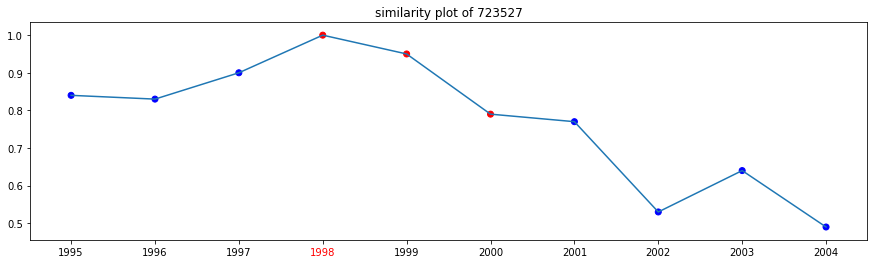

(1995, 1996, 1997, 1999, 2000, 2001)


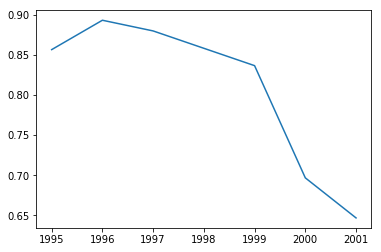

In [345]:
plot_similarity(cik_keep[130], summary, text_keep)

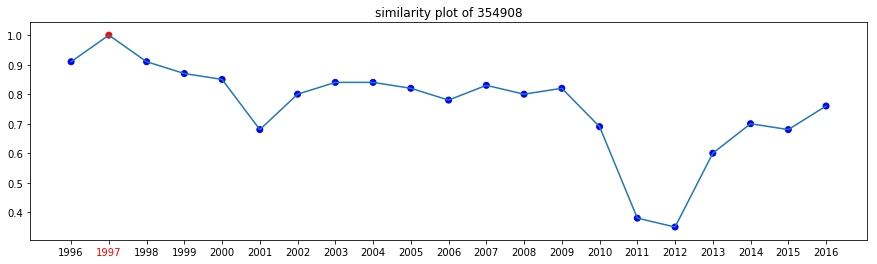

(1996, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013)


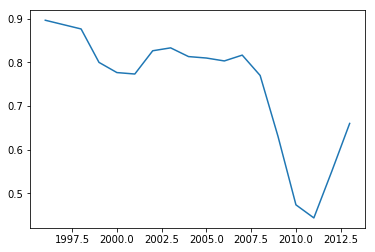

In [346]:
plot_similarity(cik_keep[136], summary, text_keep)

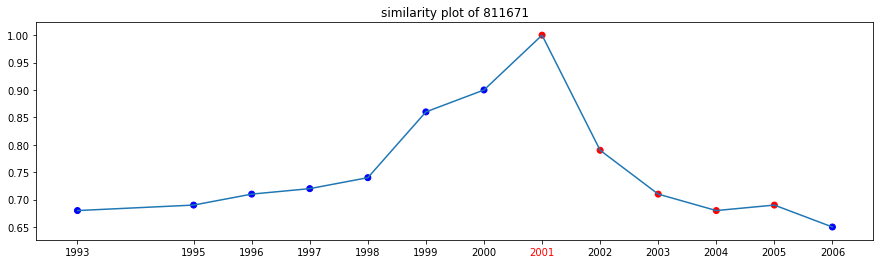

(1993, 1995, 1996, 1997, 1998, 1999, 2000, 2002, 2003)


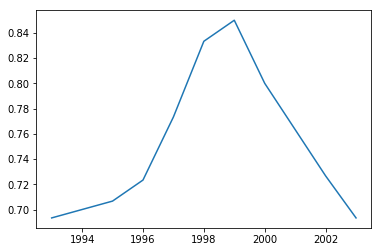

In [347]:
plot_similarity(cik_keep[155], summary, text_keep)

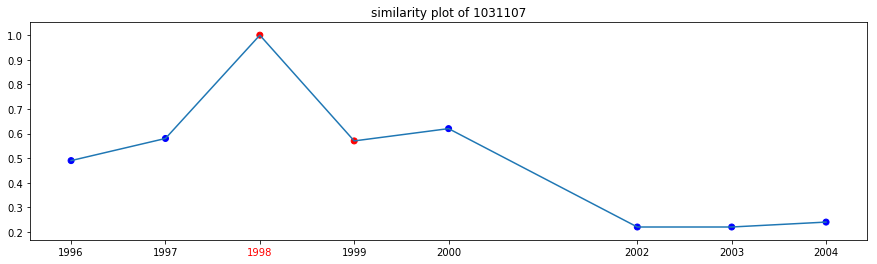

(1996, 1997, 1999, 2000)


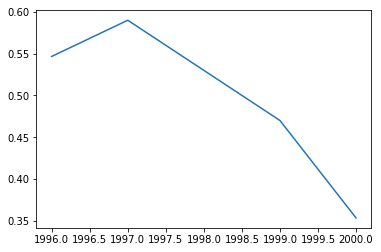

In [349]:
plot_similarity(cik_keep[235], summary, text_keep)